# Stochastic SIR model

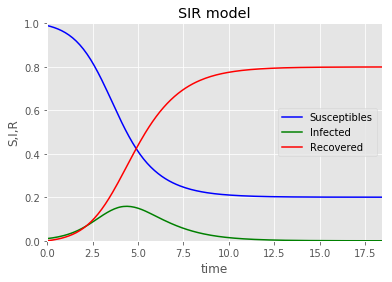

KeyboardInterrupt: 

In [3]:
import networkx as nx
import matplotlib.pylab as plt
import random as rd
import math
import os
import glob
import numpy as np
import nbimporter
from pySIR import *
%matplotlib inline

"""
This script runs and analyses a stochastic SIR model simulation

- uses graphs to add spatial inhomogeneity and stochasticity
- compares between 
       * deterministic homogeneous SIR, 
       * inhomogeneous (trajectory-averaged) SIR, 
       * fully stochastic SIR
       
 - TODO:
       * What is the correspondig R_0 of the stochastic simulation? Can it be defined a priori based on
         node change rates?
       * Compare number of events (stochastic way) vs real times (differential eqs. way)
       * Compute average of trajectories
       * Upgrade plot
"""

# Functions
def get_graph(n_nodes,n_edges,plot=False):
    """
    Produce a Barabasi-Albert graph
    """
    graph = nx.barabasi_albert_graph(n_nodes, n_edges)
    if plot: nx.draw_spring(graph, node_color='b', node_size=30, with_labels=False)

    return graph

def setup_graph(graph):
    """
    Set up initial state of the graph
    """
    infected  = {} # infected[i]=1 means the node is infected, infected[i]=0 means the node is healthy
    recovered = {} # recovered[i]=1 means the node has recovered, recovered[i]=1 means it hasn't
    
    for node in graph:
        infected[node]  = 0
        recovered[node] = 0
    
    patient_zero = rd.choice(list(graph.nodes())) # If this node is close to a cluster in the graph: superspreading!
    infected[patient_zero] = 1
    
    return infected, recovered

def event_rates(graph,infection_rates,cumulative_rates,infection_coeff,recovery_coeff,recovered,infected,not_recovered_nodes,eps=1e-9):
    """
    Update the infection and recovery rates of the stochastic SIR
    """

    for node in graph.nodes():
        infection_rates[node]  = 0
        cumulative_rates[node] = 0
    
    rate_total = 0.
    last_node = 'null'
    
    # Compute the rates of all possible events
    for node in not_recovered_nodes:
        if infected[node] == 0:
            # Rate for next infection on a node depends on state of neighbouring nodes
            infection_rates[node] = 0.
            for node_neighbour in graph[node]:
                infection_rates[node] += infection_coeff * infected[node_neighbour] 
        else:
            # Rate for recovery
            infection_rates[node] = recovery_coeff
            
        cumulative_rates[node] = cumulative_rates[last_node] + infection_rates[node]
        if cumulative_rates[node] == 0: cumulative_rates[node] = eps
        rate_total += infection_rates[node]
        last_node = node
        
        if rate_total < eps: rate_total = eps   

    return rate_total, infection_rates, cumulative_rates

def update_graph(cumulative_rates,rate_total,infected,recovered,t,delta_t,not_recovered_nodes):
    """
    Update graph status after selecting next event.
    """
    random_choice = rd.random()
    last_rate = 0
    for node in not_recovered_nodes:
        if random_choice >= last_rate and random_choice <= cumulative_rates[node] / rate_total:
            if infected[node] == 0: 
                infected[node] = 1
            elif infected[node] == 1: 
                infected[node] = 0
                recovered[node] = 1
            else:
                print("[ERROR] Something went wrong")
            t += delta_t
            break
        last_rate = cumulative_rates[node] / rate_total
        
    return t,infected,recovered

def SIR_plot_single_run(t,t_max,I,R):
    """
    Plot results of individual run
    """
    fig, ax = plt.subplots()
    
    t_min = 0
    plt.style.use('ggplot')
    ax.set_title('Stochastic SIR model')
    ax.set_xlabel('time')
    ax.set_ylabel('S,I,R')
    ax.set_xlim(t_min,t_max)
    ax.set_ylim(0,1)
    ax.plot(t,1.-I-R,'-',c='blue',label="Susceptibles")
    ax.plot(t,I,'-',c='green',label="Infected")
    ax.plot(t,R,'-',c='red',label="Recovered")

    plt.legend()
    plt.show()

def SIR_plot(t,I,R,t_max):
    """
    Plot results
    - I,R are lists of I(t) and R(t) for each of the Nrep runs
    - t_max is the max time shown on the plot (x axis)
    """
    fig, ax = plt.subplots()
    
    t_min = 0
    lw = 0.8
    plt.style.use('ggplot')
    ax.set_title('Stochastic SIR model')
    ax.set_xlabel('time')
    ax.set_ylabel('S,I,R')
    ax.set_xlim(t_min,t_max)
    ax.set_ylim(0,1)
    
    for irep in range(len(I)):
        
        if irep==0:
            ax.plot(t[irep],1.-I[irep]-R[irep],'-',c='blue',alpha=0.7,lw=lw,label="Susceptibles")
            ax.plot(t[irep],I[irep],'-',c='green',lw=lw,label="Infected")
            ax.plot(t[irep],R[irep],'-',c='red',alpha=0.7,lw=lw,label="Recovered")
        else:
            ax.plot(t[irep],1.-I[irep]-R[irep],'-',alpha=0.7,lw=lw,c='blue')
            ax.plot(t[irep],I[irep],'-',lw=lw,c='green')
            ax.plot(t[irep],R[irep],'-',alpha=0.7,lw=lw,c='red')

    plt.legend()
    plt.show()
    
# Main
if __name__ == "__main__":

    #### User-defined input parameters ####

    # Graph parameters
    n_nodes = 100
    n_edges = 2
    
    # SIR parameters
    infection_coeff = 0.2
    recovery_coeff  = 0.1
    
    # Simulation duration (number of events)
    tmax = 100
    
    # How many simulations to run
    Nrep = 100
        
    plot_individual_runs = False
    
    #### End user-defined input parameters ####
    
    if Nrep<1: raise ValueError("At least one stochastic run must be performed (set Nrep>0).")
    if n_edges!=2: raise RuntimeError("Do not fuck with things you don't understand")
    
    # [0] Get deterministic solution
    r0 = infection_coeff/recovery_coeff
    deterministic_SIR = pySIR(N_inf=1,N_pop=n_nodes,times=[0,100,1000],r0=r0,plot=True)
    
    # Stochastic simulation driver
    I_of_t_each_run = []
    R_of_t_each_run = []
    times_each_run  = []
    
    for irep in range(Nrep):

        # [1] Initialize graph
        graph = get_graph(n_nodes, n_edges)

        # [2] Initial conditions
        infected, recovered = setup_graph(graph)
    
        # [3] Continuous time simulation
        infection_rates = {}         # Array of rates
        cumulative_rates = {}        # Cumulative rates
        cumulative_rates['null'] = 0 # First event 
        t = 0                        # Event counter ("time")

        time = []
        infected_toplot = []
        recovered_toplot = []

        while t < tmax:

            not_recovered_nodes = [node for node in graph.nodes() if recovered[node]==0]

            ## [3a] Establish new event rates
            rate_total, infection_rates, cumulative_rates = \
            event_rates(graph,infection_rates,cumulative_rates,infection_coeff,recovery_coeff,recovered,infected,not_recovered_nodes)    

            ### Sampling an exponential distribution
            try: delta_t = - math.log(rd.random() ) / rate_total
            except: raise ZeroDivisionError("Something wrong: rate_total is %f but shouldn't be."%rate_total)
                
            ## [3b] Update graph status
            t,infected,recovered = update_graph(cumulative_rates,rate_total,infected,recovered,t,delta_t,not_recovered_nodes)

            ### Accumulate quantities to plot
            infected_toplot.append( sum(infected.values()) / float(n_nodes) ) 
            recovered_toplot.append( sum(recovered.values()) / float(n_nodes) )
            time.append(t)

            ### Add t=0
            infected_toplot = [1./float(n_nodes)] + infected_toplot
            recovered_toplot= [0.] + recovered_toplot
            time = [0.]+time
         
        # [4] Plot individual run
        if plot_individual_runs:
            print("Round %d of %d..."%(irep+1,Nrep))
            SIR_plot_single_run(time,tmax,np.array(infected_toplot),np.array(recovered_toplot))
        
        I_of_t_each_run.append(np.array(infected_toplot))
        R_of_t_each_run.append(np.array(recovered_toplot))
        times_each_run.append(time)
    
    # [4] Plot results
    SIR_plot(times_each_run,I_of_t_each_run,R_of_t_each_run,80)